# Pre-Test | Design the Test

## Requirements

- Independent Variable [landing page --> this is the variable we are testing]
- Dependent Variable [# converted --> this is used to calculate the conversion rate which is our KPI metric]
- Significance [alpha 0.05 | confidence level 95T]
- Sample Size [To be determined based on Power Analysis]


- KPI Metrics [13% --> 15%, 2 percent increment for conversion rate]
- Hypothesis [2 tailed test]
- H0: new_page have no significant effect on conversion rate
- H1: new_page has significant effect on conversion rate

## Power Analysis - To determine Sample Size
- Alpha = 0.05
- Power Ratio[1-beta] = 0.8 
- Determine Effective Size
- Determine Sample Size

In [1]:
# Determine effect size based on KPI Metrics
import statsmodels.api as sm
eff_size = sm.stats.proportion_effectsize(0.13, 0.15)
print(eff_size)

-0.0576728617308947


In [2]:
# Calculate Sample Size using Power Analysis
power_ratio = 0.8
sample_size = sm.stats.NormalIndPower().solve_power(eff_size, alpha = 0.05, power = power_ratio)

import math
sample_size = math.ceil(sample_size)
print(sample_size)

4720


In [3]:
# Report the amount of samples required
print(f'Both the control group and the treatment group require {sample_size} samples for the test.')

Both the control group and the treatment group require 4720 samples for the test.


# Test - Collect the Data

## Pre-process data

## Check basics
- info
- shape
- columns
- data type
- statistics

## Check for missing values, duplicates etc.

In [4]:
# Read file
import pandas as pd
df = pd.read_csv('../input/ab-testing/ab_data.csv')

In [5]:
# Check basic info on data
print(df.info())
print(df.shape)
print(df.columns)
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None
(294478, 5)
Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')
user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object


In [6]:
print(f"Unique values for group: {df['group'].unique()}")
print(f"Unique values for landing_page: {df['landing_page'].unique()}")
print(f"Unique values for converted: {df['converted'].unique()}")

Unique values for group: ['control' 'treatment']
Unique values for landing_page: ['old_page' 'new_page']
Unique values for converted: [0 1]


In [7]:
# We discovered that the timestamp is stored as an object instead of date, let's fix that
df = pd.read_csv('../input/ab-testing/ab_data.csv',parse_dates=[('timestamp')])

In [8]:
# Missing values
print(f'Are there any missing values: {df.isnull().values.any()}')

Are there any missing values: False


In [9]:
# Check that everyone from control group went to old_page and everyone from treatment group went to new_page
print(pd.crosstab(df['group'], df['landing_page']))

landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965


### We can see that almost 2k people from each group went to the wrong page

In [10]:
# Duplicate values
print(df['user_id'].value_counts())

805339    2
754884    2
722274    2
783176    2
898232    2
         ..
642985    1
771499    1
923606    1
712675    1
715931    1
Name: user_id, Length: 290584, dtype: int64


### We can see that some users appeared twice

    Total # of records: 294,478 - # of unique users: 290,584 = # of users who appeared twice: 3,894
        If we drop these users, we will be dropping 3894 * 2 = 7788 records
        This is a very small amount compared to the records we have in the dataset, we can drop these records

In [11]:
counts = df['user_id'].value_counts()
user_drop_list = counts[counts > 1].index # Make a list for the users we want to drop
df = df[~df['user_id'].isin(user_drop_list)]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286690 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       286690 non-null  int64         
 1   timestamp     286690 non-null  datetime64[ns]
 2   group         286690 non-null  object        
 3   landing_page  286690 non-null  object        
 4   converted     286690 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 13.1+ MB
None


### We see that the number of entries have reduced from 294,478 to 286,690

## Data Sampling

In [12]:
# Randomly collect samples from control group and treatment group
df_control = df[df['group'] == 'control'].sample(n=sample_size, random_state = 23)
df_treatment = df[df['group'] == 'treatment'].sample(n=sample_size, random_state = 23)
print(df_control)
print(df_treatment)

        user_id                  timestamp    group landing_page  converted
53675    834087 2017-01-18 10:09:17.394053  control     old_page          0
291060   718217 2017-01-20 22:04:31.689015  control     old_page          0
284377   639050 2017-01-12 13:36:55.215330  control     old_page          0
56998    640643 2017-01-03 06:38:40.454354  control     old_page          0
6469     818517 2017-01-05 16:51:36.579900  control     old_page          0
...         ...                        ...      ...          ...        ...
85200    920467 2017-01-21 23:27:26.237761  control     old_page          1
84140    890916 2017-01-09 07:15:17.296358  control     old_page          0
62188    634782 2017-01-22 22:54:42.661549  control     old_page          0
206933   750858 2017-01-19 00:17:16.931108  control     old_page          0
176872   631389 2017-01-14 02:51:11.103769  control     old_page          0

[4720 rows x 5 columns]
        user_id                  timestamp      group landing_p

In [13]:
# Concat the two groups to form a sample for testing
df_sample = pd.concat([df_control, df_treatment])
    #Replace index to make it look more clean
df_sample.reset_index(drop=True, inplace=True)
print(df_sample)

      user_id                  timestamp      group landing_page  converted
0      834087 2017-01-18 10:09:17.394053    control     old_page          0
1      718217 2017-01-20 22:04:31.689015    control     old_page          0
2      639050 2017-01-12 13:36:55.215330    control     old_page          0
3      640643 2017-01-03 06:38:40.454354    control     old_page          0
4      818517 2017-01-05 16:51:36.579900    control     old_page          0
...       ...                        ...        ...          ...        ...
9435   889139 2017-01-10 15:14:01.142235  treatment     new_page          0
9436   876996 2017-01-09 03:06:31.312259  treatment     new_page          0
9437   646019 2017-01-16 09:18:23.629091  treatment     new_page          0
9438   851704 2017-01-13 21:10:14.611902  treatment     new_page          0
9439   867815 2017-01-19 11:48:25.530352  treatment     new_page          0

[9440 rows x 5 columns]


### Now the data is ready for post-test analysis

# Post-Test

## Referring to the requirements, we are hoping to see the conversion rate increase from 13% to 15%

In [14]:
# Compare conversion rate between control group and treatment group
import numpy as np
c_ = df_sample.groupby('group')['converted']

# It is also useful to show STD and STR on the side
import scipy.stats as stats
stderr = lambda x: stats.sem(x)
    # Find the standard error to check the std between the sample and the population
test_summary = c_.agg([np.mean, np.std, stderr])
test_summary.columns = ['conv_rate', 'std', 'str']
print(test_summary)

           conv_rate       std       str
group                                   
control     0.121186  0.326378  0.004751
treatment   0.127754  0.333851  0.004859


<AxesSubplot:xlabel='group', ylabel='converted'>

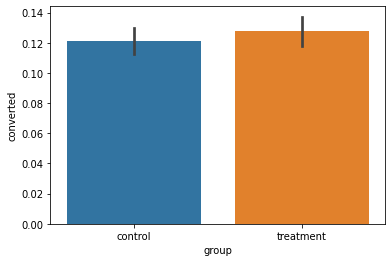

In [15]:
# Let's visualize the data
import seaborn as sns
sns.barplot(x = df_sample['group'], y = df_sample['converted'])

### As we can see, the conversion rate did not match our expectations

    We are not done however
    To determine whether or not to reject the null hypothesis, we need to look at the p-value

In [16]:
# We can run a z-test because we have a large sampling pool
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
result_control = df_sample[df_sample['group']=='control']['converted']
result_treatment = df_sample[df_sample['group']=='treatment']['converted']

n_control = result_control.count()
n_treatment = result_treatment.count()

z_stat, p_value = proportions_ztest([result_control.sum(), result_treatment.sum()], [n_control, n_treatment])
# We can also look at the confidence interval
(l_c, l_t), (u_c, u_t) = proportion_confint([result_control.sum(), result_treatment.sum()], [n_control, n_treatment], alpha = 0.05)

print(p_value)
print(f'for the control group:   [{l_c:.3f}, {u_c:.3f}]')
print(f'for the treatment group: [{l_t:.3f}, {u_t:.3f}]')

0.33378795812517914
for the control group:   [0.112, 0.130]
for the treatment group: [0.118, 0.137]


# Conclusion
We fail to reject the null hypothesis because the resulting p-value is much much higher than 0.05

Based on the the confidence interval, we observe a slight increase for the conversion rate of the treatment group. At the same time, the increase is not significant enough
    
Therefore, we have not achieved the expected result